# Disease_MeSH_Enrichment

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd
from tqdm.contrib.concurrent import process_map
import pickle

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)
mesh_tree_terms_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")
mesh_ids_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-05-08 15:22:17,364 - INFO - Nº of processed ids: 7191
2024-05-08 15:22:17,390 - INFO - Nº of processed ids in df_data_info: 7191
2024-05-08 15:22:17,392 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
logging.info(f"Loading file {mesh_tree_terms_path}")
with open(mesh_tree_terms_path, "rb") as f:
    data = pickle.load(f)
    mesh_tree_terms = data.get("mesh_tree_terms")
    mesh_dsaids = data.get("dsaids")
    mesh_ids = data.get("mesh_ids")
    dsaids_2_mesh_tree_terms = {k: v for k, v in zip(mesh_dsaids, mesh_tree_terms)}
    dsaids_2_mesh_ids = {k: v for k, v in zip(mesh_dsaids, mesh_ids)}

dsaids_with_mesh = [k for k, v in dsaids_2_mesh_tree_terms.items() if len(v) > 0]
logging.info(f"Nº of dsaids with mesh {len(dsaids_with_mesh)}")

2024-05-08 15:22:17,396 - INFO - Loading file ../data/DiSignAtlas/mesh_tree_terms.pkl
2024-05-08 15:22:17,402 - INFO - Nº of dsaids with mesh 7790


In [3]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

2024-05-08 15:23:18,773 - INFO - Nº of Human protein coding genes: 20607


In [4]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-05-08 15:23:18,869 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [5]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 2175457.28it/s]


In [6]:
import pickle

path_pkl = os.path.join("..", "data", "DiSignAtlas", "signatures.pkl")

human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

if not os.path.exists(path_pkl):

    signatures = process_map(
        get_signatures,
        human_dsaids_processed,
        max_workers=8,
        chunksize=10,
    )
    pickle.dump(signatures, open(path_pkl, "wb"))
    logging.info(f"Signatures saved {path_pkl}")

else:
    logging.info(f"Loading signatures from file {path_pkl}")
    signatures = pickle.load(open(path_pkl, "rb"))

2024-05-08 15:23:18,925 - INFO - Loading signatures from file ../data/DiSignAtlas/signatures.pkl


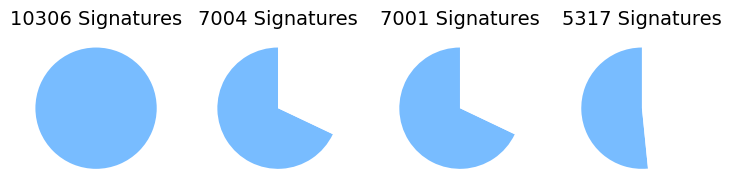

In [7]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "RNA-Seq")
        | (df_data_info["library_strategy"] == "Microarray")
    )
].shape[0]
n_step_2 = df_data_info_processed_filtered.shape[0]
n_step_3 = len(
    set(dsaids_with_mesh) & set(df_data_info_processed_filtered["dsaid"].to_list())
)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]
sizes_step_3 = [n_step_3, n_step_0 - n_step_3]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 4, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures", fontsize=14)
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures", fontsize=14)
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures", fontsize=14)
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

ax[3].pie(sizes_step_3, colors=colors, startangle=90)
ax[3].set_title(f"{n_step_3} Signatures", fontsize=14)
ax[3].set(aspect="equal")
ax[3].set_axis_off()  # Remove borders and ticks


plt.savefig(
    os.path.join("..", "results", "figures", "DiSignAtlas", "mesh.pre_process.png"),
    bbox_inches="tight",
    dpi=300,
)

In [8]:
# import matplotlib.pyplot as plt

# # Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
# n_step_0 = df_data_info.shape[0]
# n_step_1 = df_data_info[
#     (df_data_info["organism"] == "Homo sapiens")
#     & (
#         (df_data_info["library_strategy"] == "RNA-Seq")
#         | (df_data_info["library_strategy"] == "Microarray")
#     )
# ].shape[0]
# n_step_2 = df_data_info_processed_filtered.shape[0]

# # Define labels and sizes for the pie charts
# sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
# sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
# sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# # Define colors for the pie charts
# colors = ["#78bcffff", "white"]

# # Generate the pie charts without labels or percentages, only colors and titles

# plt.pie(sizes_step_2, colors=colors, startangle=90)
# plt.title(f"{n_step_2} Signatures", fontsize=14)
# # plt.set(aspect="equal")
# plt.set_axis_off()  # Remove borders and ticks

# # plt.savefig(
# #     os.path.join("..", "results", "figures", "DiSignAtlas", "pre_process.png"),
# #     bbox_inches="tight",
# #     dpi=300,
# # )

In [9]:
logging.info(
    f"Nº of non-redundant diseases initially: {df_data_info['disease'].nunique()}"
)
logging.info(
    f"Nº of non-redundant diseases after pre-processing: {df_data_info_processed_filtered['disease'].nunique()}"
)

2024-05-08 15:24:05,490 - INFO - Nº of non-redundant diseases initially: 1836
2024-05-08 15:24:05,491 - INFO - Nº of non-redundant diseases after pre-processing: 1428


In [10]:
interesting_dsaids = []
n_std = list()
vector_len = list()
for i, s in enumerate(tqdm(signatures)):
    if np.any(np.array(s[5]) > 500) or np.any(np.array(s[5]) < -500):
        interesting_dsaids.append((i, s[0], max(s[5]), min(s[5])))

    # compute std
    std = np.std(signatures[i][5])
    mean = np.mean(signatures[i][5])

    n = len(
        [
            value
            for value in signatures[i][5]
            if (value > mean + 6 * std) or (value < mean - 6 * std)
        ]
    )

    vector_len.append(len(signatures[i][5]))
    n_std.append(n)

logging.info(f"Nº of dsaids w/ extreme log2fc: {len(interesting_dsaids)}")
logging.info(f"Signatures: {interesting_dsaids}")

100%|██████████| 7001/7001 [00:35<00:00, 199.39it/s]
2024-05-08 15:24:40,608 - INFO - Nº of dsaids w/ extreme log2fc: 3
2024-05-08 15:24:40,609 - INFO - Signatures: [(3379, 'DSA04659', 283010.779335352, -99319.619817649), (3380, 'DSA04660', 367171.584055279, -408566.783065797), (6416, 'DSA09547', 61042.6740428988, -355887.1218498)]


In [11]:
# dsaid to disease
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)

## Raw Data Exploration

## Define Sparsity & Matrix Dimensions

In [12]:
""" Define Sparsity & Matrix Dimensions

Structure:
    1. Import, Variables and Functions
    2. Get the most common gene ids
    3. Get the dsaids with the most common gene ids
    4. Create the data matrix
"""

# Imports, Variables and Functions
# imports

from collections import Counter

# variabels
sparsity = "HS"
sparsity_perc_sign_thr = {"LS": 0.8878, "HS": 0.25}
sparsity_perc_genes_thr = {"LS": 0.95, "HS": 0.5}
assert sparsity in ["LS", "HS"], "Err Sparsity not recognized"


# functions
def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


# 2. Get the most common gene ids
# Map all human protein-coding genes to the signatures
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

# Get the sorted counts of protein-coding genes
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

# Get depending on the sparsity the most common gene ids of interest
most_common_gene_ids = [
    k
    for k, v in counts_all_gene_ids_protein_coding.items()
    if v >= int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))
]

logging.info(
    f"{sparsity} Most common gene ids: {len(most_common_gene_ids)} for {sparsity} >= {int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))} / {len(signatures)}"
)

# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)


# 3. Get the dsaids with the most common gene ids
# dsaids w/ gene ids
# loop through signatures and get dsaids with an intersection against
# the most common gene ids above or equal to a threshold
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    >= int(len(most_common_gene_ids) * sparsity_perc_genes_thr.get(sparsity))
]

dsaids_filtered_mesh = [d for d in dsaids_common_gene_ids if d in dsaids_with_mesh]

logging.info(
    f"Nº of dsaids w/ common gene ids {sparsity}: {len(dsaids_common_gene_ids)}"
)

logging.info(
    f"Nº of dsaids w/ common gene ids & mesh tree terms {len(dsaids_filtered_mesh)}"
)

# 4. Create the data matrix
# create data matrix
data_matrix = np.zeros((len(dsaids_filtered_mesh), len(most_common_gene_ids)))

logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")

2024-05-08 15:25:01,783 - INFO - HS Most common gene ids: 18561 for HS >= 1750 / 7001
2024-05-08 15:25:08,251 - INFO - Nº of dsaids w/ common gene ids HS: 6513
2024-05-08 15:25:08,251 - INFO - Nº of dsaids w/ common gene ids & mesh tree terms 4936
2024-05-08 15:25:08,252 - INFO - Data matrix HS shape: (4936, 18561)


In [13]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  all_gene_ids: 1008.0 MiB
                   data_matrix: 699.0 MiB
                  df_data_info:  8.9 MiB
        df_data_info_processed:  6.3 MiB
df_data_info_processed_filtered:  6.1 MiB
           counts_all_gene_ids:  2.5 MiB
counts_all_gene_ids_protein_coding: 576.1 KiB
      dsaids_2_mesh_tree_terms: 288.1 KiB
             dsaids_2_mesh_ids: 288.1 KiB
               dsaid_2_disease: 288.1 KiB


In [14]:
from scipy import stats

In [15]:
stats.false_discovery_control

<function scipy.stats._morestats.false_discovery_control(ps, *, axis=0, method='bh')>

### Compute Matrix

In [16]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# variables
metric_evaluated = "iLINCS.100"

d_default_value = {
    "PValue": 0.0,
    "AdjPValue": 1.0,
    "Log2FC": 0.0,
    "ReAdjPValue": 0.0,
    "iLINCS.100": 0.0,
    "iLINCS.200": 0.0,
    "iLINCS.all": 0.0,
    "iLINCS.ReAdj": 0.0,
    "Ranking.AdjPValue": 0.0,
    "Ranking.Log2FC": 0.0,
    "Significant.Log2FC": 0.0,
    "Significant.Log2FC.ReAdj": 0.0,
    "Filtered.Log2FC": 0.0,
}

variance_thr = 0.0
de_genes_thr = 30

assert metric_evaluated in [
    "PValue",
    "AdjPValue",
    "Log2FC",
    "ReAdjPValue",
    "iLINCS.100",
    "iLINCS.200",
    "iLINCS.all",
    "iLINCS.ReAdj",
    "Ranking.AdjPValue",
    "Ranking.Log2FC",
    "Significant.Log2FC",
    "Filtered.Log2FC",
    "Significant.Log2FC.ReAdj",
], "Err metric not found"


# functions


def filter_information(reference, labels, values):
    """Filter information by reference
    Args:
        - reference (list): list of reference ids
        - labels (list): list of labe{sparsity}
        - values (list): list of values
    Returns:
        - labels (np.array): np.array of labels
        - values (np.array): np.array of values
    """
    reference = np.array(reference)
    labels = np.array(labels)
    values = np.array(values)
    mask = np.isin(labels, reference)
    return labels[mask], values[mask]


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


def adjust_p_values(reference, labels, values, method="fdr_bh"):
    values = np.array(values)
    d = dict(zip(labels, values))

    # common labels between reference and labels
    common_labels = list(set(reference).intersection(set(labels)))

    # get values
    values = [d[k] for k in common_labels]

    if method == "fdr_bh":
        # adjust p-values
        adjusted_values = stats.false_discovery_control(values)

    # possible other methods (?)

    return common_labels, adjusted_values


def compute_signed_significance(p_values, log2fcs):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    p_values = np.array(p_values)
    log2fcs = np.array(log2fcs)

    assert len(p_values) == len(log2fcs), "Err p_values and log2fcs not same length"
    signed_significance = list()
    for p_value, logfc in zip(p_values, log2fcs):
        # P Value should neve be 0
        if p_value == 0:
            p_value = min(p_values[p_values != 0])
        # chek if p_value is nan
        if not np.isnan(p_value):
            sign = np.sign(logfc)
            ss = sign * (-np.log10(p_value))
            signed_significance.append(ss)
        if np.isnan(p_value):
            raise ValueError("Log2FC is nan")
    return np.array(signed_significance)


def compute_extreme_signed_significance(signed_significance, genes, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance (np.array): list of signed significance

    - genes (np.array): list of gene ids

    - k: int()
        Top/Bottom k genes.

    Returns:
    - genes: list of gene ids
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # check if there are nans in the signed significance
    signed_significance_no_nan = signed_significance[~np.isnan(signed_significance)]
    signed_significance_nan = signed_significance[np.isnan(signed_significance)]

    genes_no_nan = genes[~np.isnan(signed_significance)]
    genes_nan = genes[np.isnan(signed_significance)]

    # Sort the signed_significance_no_nan in ascending order and get sorted indices
    sorted_indices = np.argsort(signed_significance_no_nan)

    # Apply sorting to both signed_significance_no_nan and genes_no_nan
    sorted_signed_significance_no_nan = signed_significance_no_nan[sorted_indices]
    sorted_genes_no_nan = genes_no_nan[sorted_indices]

    # Initialize a mask for all values as False (indicating all will be set to 0)
    mask = np.zeros(sorted_signed_significance_no_nan.shape, dtype=bool)

    # if there are 0s in the top or bottom 100 then they will be still 0's
    # after the mask

    if k:
        # Set True for the top 100 (smallest) and bottom 100 (largest) values in ascending order
        mask[:k] = True  # Smallest values
        mask[-k:] = True  # Largest values before NaNs

        # Apply the mask, setting values not in the top or bottom 100 to 0
        sorted_signed_significance_no_nan[~mask] = 0

    # Concatenate with NaN parts
    final_signed_significance = np.concatenate(
        [sorted_signed_significance_no_nan, signed_significance_nan]
    )
    final_genes = np.concatenate([sorted_genes_no_nan, genes_nan])
    return final_genes, final_signed_significance


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking


def get_significant_log2fc(
    log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
):
    """Get significant log2fc
    Arguments:
        - log2fc (list): list of log2fc
        - adj_p_values (list): list of adj_p_values
        - thr_log2fc (float): threshold for log2fc
        - thr_adj_p_values (float): threshold for adj_p_values
    Returns:
        - significant_log2fc (list): list of significant log2fc
    """
    if normalize:
        # to do
        pass
    else:
        significant_log2fc = list()
        for i in range(len(log2fc)):
            if (abs(log2fc[i]) >= thr_log2fc) and (adj_p_values[i] <= thr_adj_p_values):
                significant_log2fc.append(log2fc[i])
            else:
                significant_log2fc.append(np.nan)
        return np.array(significant_log2fc)


def get_filtered_log2fc(log2fc, winsorize_limit=0.001):
    """Get filtered log2fc
    Returns:
        - log2fc (list): list of log2fc
    """
    # imports
    from scipy.stats.mstats import winsorize
    import numpy as np

    # using scikit-learn's MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler

    # Winsorizing data
    log2fc_winsorized = winsorize(np.array(log2fc), limits=winsorize_limit).data

    # Convert masked array to numpy array
    log2fc_winsorized = np.array(log2fc_winsorized.data)
    # Create a MinMaxScaler object with range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Normalize the data
    # Reshape data for the scaler
    log2fc_normalized = scaler.fit_transform(log2fc_winsorized.reshape(-1, 1))
    return log2fc_normalized.flatten()


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
zero_significant_dsaids = list()
dsaids_matrix = list()
rows_filled = 0
if metric_evaluated.startswith("iLINCS"):
    n_ess = list()

for i, dsaid_specific in enumerate(tqdm(dsaids_filtered_mesh)):
    if dsaid_specific == "DSA04660":
        continue
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )

    elif metric_evaluated == "PValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated == "ReAdjPValue":

        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated.startswith("iLINCS"):
        """Wer are computing the extreme signed significance for
        those genes of interest. Not for all genes. This is a decision
        which is arbitrary. Justification is that we are interested in
        the scope of genes of interest.
        """

        if metric_evaluated == "iLINCS.ReAdj":
            # re-adjust p-values
            common_gene_ids, re_adj_p_values = adjust_p_values(
                reference=most_common_gene_ids, labels=gene_ids, values=p_values
            )

            # order log2fc same order as adj_p_values
            d_log2fc = dict(zip(gene_ids, log2fc))
            ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

            # re-define variables for later
            log2fc = ordered_log2fc
            adj_p_values = re_adj_p_values
            gene_ids = common_gene_ids

        # filter adj_p_values
        filtered_gene_ids, filtered_adj_p_values = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=adj_p_values
        )

        # filter log2fc
        filtered_gene_ids, filtered_log2fc = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=log2fc
        )

        # compute signed significance
        signed_significance = compute_signed_significance(
            filtered_adj_p_values, filtered_log2fc
        )

        k_ilincs = (
            False
            if metric_evaluated == "iLINCS.all" or metric_evaluated == "iLINCS.ReAdj"
            else int(metric_evaluated.split(".")[1])
        )

        # compute extreme signed significance
        gene_ids_ess, ess = compute_extreme_signed_significance(
            signed_significance=signed_significance,
            genes=filtered_gene_ids,
            k=k_ilincs,
        )

        # sort values
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids_ess,
            values=ess,
        )

    if metric_evaluated == "Ranking.AdjPValue":

        # compute ranking
        ranking = compute_ranking_adj_pvalue(adj_p_values, n=200, threshold=0.05)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Ranking.Log2FC":

        # compute ranking
        ranking = compute_ranking_log2fc(log2fc, n=100, threshold=0.5)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Significant.Log2FC":

        # compute ranking
        significant_log2fc = get_significant_log2fc(
            log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
        )

        if np.any(significant_log2fc) < -1:
            break

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Significant.Log2FC.ReAdj":
        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        # order log2fc same order as adj_p_values
        d_log2fc = dict(zip(gene_ids, log2fc))
        ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

        # get significant log2fc
        significant_log2fc = get_significant_log2fc(
            ordered_log2fc,
            re_adj_p_values,
            thr_log2fc=0,
            thr_adj_p_values=0.05,
            normalize=False,
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=common_gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Filtered.Log2FC":
        # compute filtered log2fc
        filtered_log2fc = get_filtered_log2fc(log2fc, winsorize_limit=0.001)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=filtered_log2fc,
        )

    # check variance for specific genes
    # check if there are significant genes here
    if len(np.array(sorted_values)[~np.isnan(sorted_values)]) == 0:
        zero_significant_dsaids.append(dsaid_specific)
        continue

    if np.var(np.array(sorted_values)[~np.isnan(sorted_values)]) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)

        continue

    # check nº of extreme signed significance genes
    if metric_evaluated.startswith("iLINCS"):
        ess_no_nan = ess[~np.isnan(ess)]
        if np.array(ess_no_nan, dtype="bool").sum() <= de_genes_thr:
            continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix = data_matrix[:rows_filled, :]
logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")


# report how many dsaids have zero variance
logging.info(
    f"{sparsity} Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}"
)
logging.info(
    f"{sparsity} Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix.shape[1]):
    if np.var(data_matrix[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix.shape[0]):
    if np.var(data_matrix[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"

# check de genes in iLINCS processing
for row in range(data_matrix.shape[0]):
    if data_matrix[row, :].astype(bool).sum() <= de_genes_thr:
        raise ValueError(f"{sparsity} Err nº of DE genes <= {de_genes_thr}")

# mask where there are nans
nan_mask = np.isnan(data_matrix)

# assign nans default value
data_matrix[nan_mask] = d_default_value.get(metric_evaluated)

100%|██████████| 4936/4936 [03:37<00:00, 22.74it/s]
2024-05-08 15:28:45,595 - INFO - Data matrix HS shape: (4917, 18561)
2024-05-08 15:28:45,595 - INFO - HS Zero variance dsaids all genes: 15
2024-05-08 15:28:45,595 - INFO - HS Zero variance dsaids specific genes: 0


In [17]:
np.max(data_matrix)

317.08724759659333

In [18]:
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

logging.info(f"Nº signatures {df_matrix.shape[0]}")
logging.info(f"Nº unique diseases {df_matrix['disease'].nunique()}")

2024-05-08 15:28:46,754 - INFO - Nº signatures 4917
2024-05-08 15:28:46,755 - INFO - Nº unique diseases 802


In [19]:
metric_evaluated = "iLINCS" if metric_evaluated == "iLINCS.100" else metric_evaluated

### Diagnostic plots

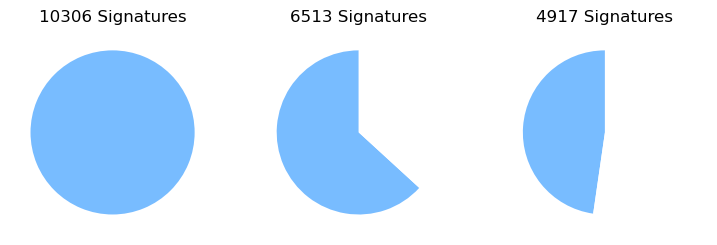

In [20]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = len(dsaids_common_gene_ids)
n_step_2 = len(dsaids_matrix)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures")
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures")
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures")
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join(
        "..", "results", "figures", "DiSignAtlas", f"mesh.data_process.{sparsity}.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

In [21]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_filtered_mesh])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases in df: {len(diseases_to_check)}")

# get disease to dsaids of interest
disease_2_dsaid_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    # if disease in diseases_to_check:
    # check if dsaids are in matrix ids
    if dsaid in dsaids_matrix:
        if disease not in disease_2_dsaid_filtered.keys():
            disease_2_dsaid_filtered[disease] = list()
        disease_2_dsaid_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in disease_2_dsaid_filtered.items() if len(v) >= 5]

logging.info(f"Nº of most common diseases in matrix: {len(most_common_diseases)}")

2024-05-08 15:28:46,915 - INFO - Nº of most common diseases in df: 209
2024-05-08 15:28:47,092 - INFO - Nº of most common diseases in matrix: 209


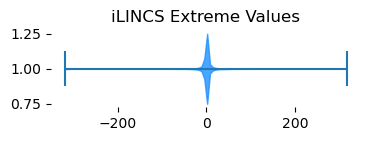

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'data_matrix' and 'metric_evaluated' are defined
# Compute percentiles to focus on extreme values
values = data_matrix.flatten()

# Create the violin plot horizontally
plt.figure(figsize=(4, 1))  # Adjusted aspect ratio for horizontal plot
violin_parts = plt.violinplot(
    values,
    vert=False,  # Make the plot horizontal
    showmeans=False,
    showmedians=False,
    showextrema=True,
)

# Customize the appearance
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("#1E90FF")
violin_parts["bodies"][0].set_alpha(0.8)

# Remove x ticks and adjust y ticks to the right
# plt.yticks([])
# plt.tick_params(axis="x", which="both", length=0)

# Remove the spines
for spine in ["top", "bottom", "left", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Adjust title based on length
title = f"{metric_evaluated} Extreme Values"
if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")

In [23]:
np.max(data_matrix.flatten())

317.08724759659333

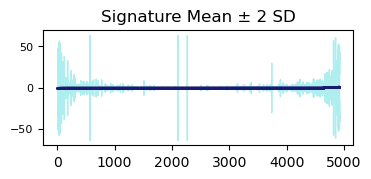

In [24]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=1)
std_devs = n_std * data_matrix.std(axis=1)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[0]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[0]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)

if log_scale:
    plt.yscale("symlog")
    plt.title(f"Signature Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Signature Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.xlim(0 - 100, data_matrix.shape[0] + 100)
plt.grid(False)

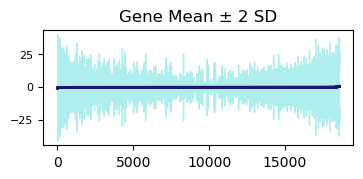

In [25]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=0)
std_devs = n_std * data_matrix.std(axis=0)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[1]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[1]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)
if log_scale:
    plt.yscale("symlog")
    plt.title(f"Gene Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Gene Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.ylabel("Mean Values")
# plt.legend()
plt.grid(False)
# plt.xlim(0 - 100, data_matrix.shape[1] + 100)

In [26]:
# count how many dsaids have data


# count how many dsaids have information
# count nans from the pre-computed matrix

### Compute Similarities

In [27]:
# imports
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random

# variables


#  functions


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

In [28]:
related_dsaids = []
for dsaid in dsaids_filtered_mesh:
    if dsaid in dsaids_2_mesh_tree_terms.keys():
        related_dsaids.extend(dsaids_2_mesh_tree_terms[dsaid])
unrrelated_dsaids = []

In [29]:
# def check_related_dsaids(, related_dsaids):

all_related_dsaids = list()
all_unrelated_dsaids = list()
# check that all same diseases are related through mesh terms
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    for dsaid in dsaids_interest:
        _dsaids_interest = dsaids_interest.copy()
        _dsaids_interest.remove(dsaid)
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in _dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )
        _dsaids_interest_mesh_terms = [d for d in _dsaids_interest_mesh_terms]

        dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
        dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        switch = False
        for dsaid_mesh_term in dsaid_mesh_terms:
            if dsaid_mesh_term in _dsaids_interest_mesh_terms:
                switch = True
                break
        if switch:
            related_dsaids.append(dsaid)
        else:
            unrrelated_dsaids.append(dsaid)

    all_related_dsaids.append(related_dsaids)
    all_unrelated_dsaids.append(unrrelated_dsaids)

100%|██████████| 209/209 [00:00<00:00, 10108.50it/s]


In [30]:
[a for a, b in zip(most_common_diseases, all_unrelated_dsaids) if len(b) > 0]

[]

In [31]:
dsaids = disease_2_dsaid_filtered.get("Depression")
for dsaid in dsaids:
    print(dsaid, dsaids_2_mesh_tree_terms.get(dsaid, []))

DSA00787 ['F03.600.300']
DSA03519 ['F03.600.300']
DSA03522 ['F03.600.300']
DSA04490 ['F03.600.300']
DSA06870 ['F03.600.300']


In [32]:
def check_common_mesh_terms(list_1, list_2, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - list_2 (list): list of mesh terms
        - level (int): level of mesh terms
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    list_2 = [
        ".".join(l.split(".")[:level]) for l in list_2 if len(l.split(".")) >= level
    ]
    if len(set(list_1).intersection(set(list_2))) > 0:
        return True
    else:
        return False

In [33]:
def check_mesh_level(list_1, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - level (int): mesh level - 1 is root
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    if len(list_1) >= 1:
        return True
    else:
        return False

In [34]:
c = 0
level = 7
for count, disease in enumerate(
    tqdm(most_common_diseases)
):  # loop through diseases of interest
    # dsaids w/ diseases of interest
    related_dsaids = list()
    unrrelated_dsaids = list()
    dsaids_interest = disease_2_dsaid_filtered.get(disease)
    _dsaids_interest_mesh_terms = list(
        {
            mesh_term
            for d in dsaids_interest
            for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
        }
    )
    if check_mesh_level(_dsaids_interest_mesh_terms, level=level):
        # print(disease)
        c += 1

print(c)

100%|██████████| 209/209 [00:00<00:00, 141183.69it/s]

41


In [35]:
def generate_matrix_idxs(interest_idxs, rest_idxs=None, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """

    if rest_idxs is None:  # generate idxs agains itself
        matrix = np.empty((len(interest_idxs), len(interest_idxs) - 1, 2), dtype=int)
        rest_idxs = interest_idxs
    else:
        matrix = np.empty((len(interest_idxs), len(rest_idxs), 2), dtype=int)

    if bootstrap:
        # this is bc when we compare same samples we
        # remove itself - so we do the same here
        n_sample_idxs = len(interest_idxs)
        matrix = np.empty((len(interest_idxs), n_sample_idxs * 100, 2), dtype=int)
        # generate bootstrap indexes
        sample_idxs = np.empty(n_sample_idxs * 100, dtype=int)
        for i in range(100):
            _sample = np.random.choice(rest_idxs, size=n_sample_idxs, replace=True)
            sample_idxs[i * n_sample_idxs : (i + 1) * n_sample_idxs] = _sample

        # redefine rest indexes
        rest_idxs = sample_idxs

    for i, idx_interest in enumerate(interest_idxs):
        j = 0
        for idx_other in rest_idxs:
            if idx_interest != idx_other:  # in case that it is the same list
                matrix[i, j] = [idx_interest, idx_other]
                j += 1
    return matrix

## Get N closest dsaids

In [112]:
# get mesh terms w/ common roots

l_1 = ["C04.588.274.476.767", "C06.301.371.767", "C06.405.249.767", "C06.405.748.789"]
l_2 = [
    "D02.705.400.625.800",
    "D02.705.539.345.800",
    "D02.886.300.692.800",
    "C04.588.274.476",
    "C06.301.371",
]

common_terms = get_common_terms(l_1, l_2, mesh_level=0)

closeness = list()
for term_1, term_2 in common_terms:
    closeness.append(get_mesh_closeness(term_1, term_2))

In [228]:
def get_common_terms(mesh_terms_1, mesh_terms_2, mesh_level=0):
    """Get Same Root MeSH Terms
    Arguments:
        - mesh_terms_1 (list): mesh terms
        - mesh_terms_2 (list): mesh terms
    Returns:
        - common_mesh_terms (list): common mesh terms
    """
    common_mesh_terms = list()

    # get mesh terms which share same root
    for mesh_term_1 in mesh_terms_1:
        for mesh_term_2 in mesh_terms_2:
            _mesh_term_1 = ".".join(mesh_term_1.split(".")[: mesh_level + 1])
            _mesh_term_2 = ".".join(mesh_term_2.split(".")[: mesh_level + 1])
            if _mesh_term_1 == _mesh_term_2:
                common_mesh_terms.append((mesh_term_1, mesh_term_2))
    return common_mesh_terms


def get_mesh_closeness(mesh_term_1, mesh_term_2):
    """Get Mesh Closeness
    Arguments:
        - mesh_term_1 (str): mesh term
        - mesh_term_2 (str): mesh term
    Returns:
        - closeness (int): closeness
    """
    # quality check
    assert mesh_term_1.split(".")[0] == mesh_term_2.split(".")[0], "Err Not same root"

    # compute how many levels are in each term
    n_steps_1 = len(mesh_term_1.split("."))
    n_steps_2 = len(mesh_term_2.split("."))

    # compute at which level they are common
    n_common_steps = 0
    extra_step = 0
    for i in range(0, min(n_steps_1, n_steps_2)):
        # if not the same break
        if mesh_term_1.split(".")[i] != mesh_term_2.split(".")[i]:
            extra_step = 1
            break
        # if same increment nº common steps
        n_common_steps += 1

    # compute closeness
    closeness = n_steps_1 + n_steps_2 - 2 * n_common_steps + extra_step
    return closeness


def get_mesh_steps(
    list_idxs_1,
    list_idxs_2,
    dsaids_2_mesh_tree_terms=dsaids_2_mesh_tree_terms,
):
    """Get MeSH Steps
    Arguments:
        - list_idxs_1 (list): list of idxs
        - list_idxs_2 (list): list of idxs
    Returns:
        - closeness (list): list of closeness length of list_idxs_1
                            and within sublists each of lenght of
                            list_idxs_2
    """
    closeness = list()
    for i, idx_1 in enumerate(list_idxs_1):
        closeness_per_sig = list()

        # get mesh for disease interest
        dsaid_interest = dsaids_matrix[idx_1]
        mesh_interest = dsaids_2_mesh_tree_terms.get(dsaid_interest)

        # get mesh for k diseases
        for idx_2 in list_idxs_2[i]:
            dsaid_k = dsaids_matrix[idx_2]
            mesh_k = dsaids_2_mesh_tree_terms.get(dsaid_k)

            # check that both are not None (shouldn't happend)
            if mesh_interest is not None and mesh_k is not None:

                # get common terms
                common_terms = get_common_terms(mesh_interest, mesh_k)

                # if there are terms in common - report how close
                # if not the list is empty
                if len(common_terms) > 0:
                    found_closeness = list()
                    for term_1, term_2 in common_terms:
                        found_closeness.append(get_mesh_closeness(term_1, term_2))

                    closeness_per_sig.append(min(found_closeness))
                else:
                    closeness_per_sig.append(np.nan)
            else:
                closeness_per_sig.append(np.nan)

        # store for each signature their found "closeness"
        closeness.append(closeness_per_sig)
    return closeness

In [249]:
# Assuming `data_matrix` is your feature matrix where rows are disease signatures
num_diseases = len(most_common_diseases)

copy_matrix_pearson_correlation = np.copy(matrix_pearson_correlation)
np.fill_diagonal(copy_matrix_pearson_correlation, 0)

copy_matrix_cosine_distance = np.copy(matrix_cosine_distance)
np.fill_diagonal(copy_matrix_cosine_distance, 1)

copy_matrix_euclidean_distance = np.copy(matrix_euclidean_distance)
np.fill_diagonal(copy_matrix_euclidean_distance, np.inf)


def get_top_index(matrix, interest_idxs, k, top=True, random=False):
    """Get Top Index
    Arguments:
        - matrix (np.array): matrix
        - interest_idxs (list): list of indexes
        - k (int): nº of top indexes
        - top (bool): top or bottom
    Returns:
        - result_idxs (list): list of top indexes
    """
    if not random:
        if top:
            result_idxs = np.argpartition(matrix[interest_idxs], -k, axis=1)[:, -k:]
        else:
            result_idxs = np.argpartition(matrix[interest_idxs], k, axis=1)[:, :k]

    elif random:
        rest_idxs = list(set(range(matrix.shape[0])) - set(interest_idxs))
        result_idxs = np.empty((len(interest_idxs), k), dtype=int)
        for i in range(len(interest_idxs)):
            _found = np.random.choice(rest_idxs, size=k, replace=False)
            result_idxs[i] = _found
    return result_idxs


correlation_k = dict()
cosine_k = dict()
euclidean_k = dict()

for k, random in [(1, False), (3, False), (10, False), (50, False), (50, True)]:

    key = k
    if random:
        key = "random"

    correlation_k[key] = list()
    cosine_k[key] = list()
    euclidean_k[key] = list()

    for idx, disease in tqdm(enumerate(most_common_diseases)):

        # dsaids w/ diseases of interest
        QUERY = f"disease == @disease"
        df_query = df_matrix.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()
        interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

        correlation_k_index = get_top_index(
            matrix=copy_matrix_pearson_correlation,
            interest_idxs=interest_idxs,
            k=k,
            top=True,
            random=random,
        )

        steps = get_mesh_steps(
            list_idxs_1=interest_idxs, list_idxs_2=correlation_k_index
        )

        # compute & store MeSH steps
        correlation_k[key].append(steps)

        cosine_k_index = get_top_index(
            matrix=copy_matrix_cosine_distance,
            interest_idxs=interest_idxs,
            k=k,
            top=False,
            random=random,
        )

        # compute & store MeSH steps
        steps = get_mesh_steps(list_idxs_1=interest_idxs, list_idxs_2=cosine_k_index)

        cosine_k[key].append(steps)

        euclidean_k_index = get_top_index(
            matrix=copy_matrix_euclidean_distance,
            interest_idxs=interest_idxs,
            k=k,
            top=False,
            random=random,
        )
        # compute & store MeSH steps
        steps = get_mesh_steps(list_idxs_1=interest_idxs, list_idxs_2=euclidean_k_index)
        euclidean_k[key].append(steps)

# del (
#     copy_matrix_pearson_correlation,
#     copy_matrix_cosine_distance,
#     copy_matrix_euclidean_distance,
# )

209it [00:00, 340.99it/s]
209it [00:01, 195.21it/s]
209it [00:01, 136.33it/s]
209it [00:03, 52.89it/s] 
209it [00:04, 44.40it/s]


In [331]:
from scipy.interpolate import make_interp_spline


def flatten(list_of_lists):
    """Flatten
    Arguments:
        - list_of_lists (list): list of lists

    Returns:
        - flatten_list (list): list
    """
    return [x for sublist in list_of_lists for x in sublist]


def create_composite_histogram(distributions, bin_edges, is_list=False):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    process = lambda val: 15 if np.isnan(val) else val

    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        dist_values = flatten(dist)
        dist_values = [process(x) for x in dist_values]
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram


# functions
def plot_metrics(
    values_list,
    labels,
    metric_evaluated,
    metric,
    save=True,
    values_per_disease=True,
):

    # define variables

    colors = {0: "darkgrey", 1: "#006400", 2: "#088F8F", 3: "#AFEAAA", 4: "#DFFF00"}

    e_max = 10
    e_step = 0.5
    fixed_bins = np.arange(0, 15.01, 1)
    plt.figure(figsize=(4, 4))
    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        if values_per_disease:
            # compute normalized density counts for each distribution
            counts = create_composite_histogram(values, fixed_bins)
        else:
            counts, _ = np.histogram(values, bins=fixed_bins)
            counts = counts / len(values)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

        # plt.bar(
        #     bin_centers,
        #     counts,
        #     label=label,
        #     width=1,
        #     align="center",
        #     alpha=alpha,
        #     color=color,
        #     edgecolor=color,
        # )

    plt.title(f"{metric_evaluated} Nº MeSH tree steps for\n{metric} k-closest signatures", fontsize=10)

    # plt.suptitle("Nº MeSH tree steps for k-cl", y=0.95)
    plt.legend()
    plt.xlabel(f"Nº of Tree Steps")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )

    plt.ylabel("Density")

    # Set x-axis ticks (ensure the last tick is at 15)
    plt.xticks(np.arange(0, 16, 1))  # Adjust the step as necessary

    # Retrieve current labels
    current_labels = [item.get_text() for item in plt.gca().get_xticklabels()]

    current_labels = [str(x) if int(x) % 2 == 0 else "" for x in current_labels]

    # Modify the last label
    if current_labels:
        current_labels[-2] = "+14\nor unrelated"  # Change the last label to "+15"
    current_labels[-1] = ""

    # Set the new labels
    plt.xticks([e + 0.5 for e in range(len(current_labels))])
    plt.gca().set_xticklabels(current_labels)

    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"k_closest.{metric}.{metric_evaluated}.mesh_enrichment.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

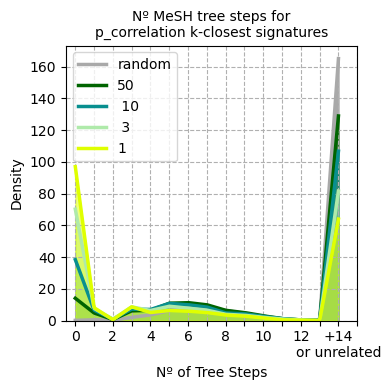

In [332]:
values_list = [
    correlation_k.get("random"),
    correlation_k.get(50),
    correlation_k.get(10),
    correlation_k.get(3),
    correlation_k.get(1),
]
labels = [
    "random",
    "50",
    " 10",
    " 3",
    "1",
]

plot_metrics(
    values_list,
    labels,
    metric="p_correlation",
    metric_evaluated=metric_evaluated,
    save=True,
    values_per_disease=True,
)

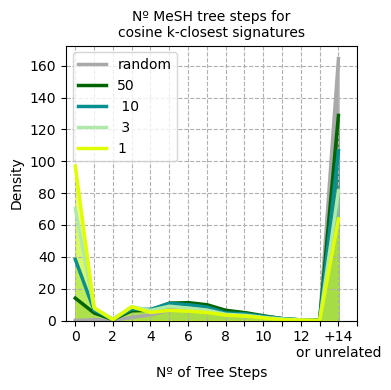

In [333]:
values_list = [
    cosine_k.get("random"),
    cosine_k.get(50),
    cosine_k.get(10),
    cosine_k.get(3),
    cosine_k.get(1),
]
labels = [
    "random",
    "50",
    " 10",
    " 3",
    "1",
]

plot_metrics(
    values_list,
    labels,
    metric_evaluated=metric_evaluated,
    metric="cosine",
    save=True,
    values_per_disease=True,
)

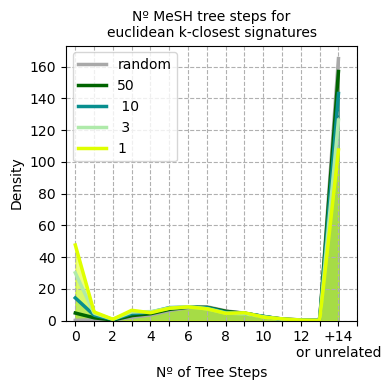

In [334]:
values_list = [
    euclidean_k.get("random"),
    euclidean_k.get(50),
    euclidean_k.get(10),
    euclidean_k.get(3),
    euclidean_k.get(1),
]
labels = [
    "random",
    "50",
    " 10",
    " 3",
    "1",
]

plot_metrics(
    values_list,
    labels,
    metric="euclidean",
    metric_evaluated=metric_evaluated,
    save=True,
    values_per_disease=True,
)